Loading data...
Calculating Mutual Information...

Calculating Distance Correlation Matrix (this may take a while)...


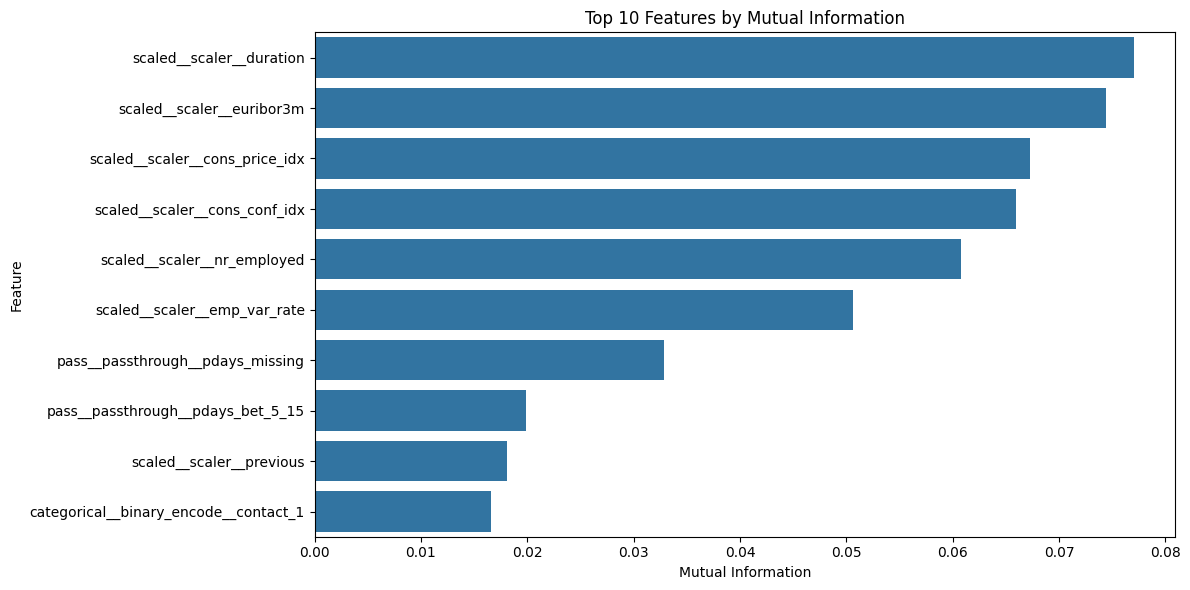

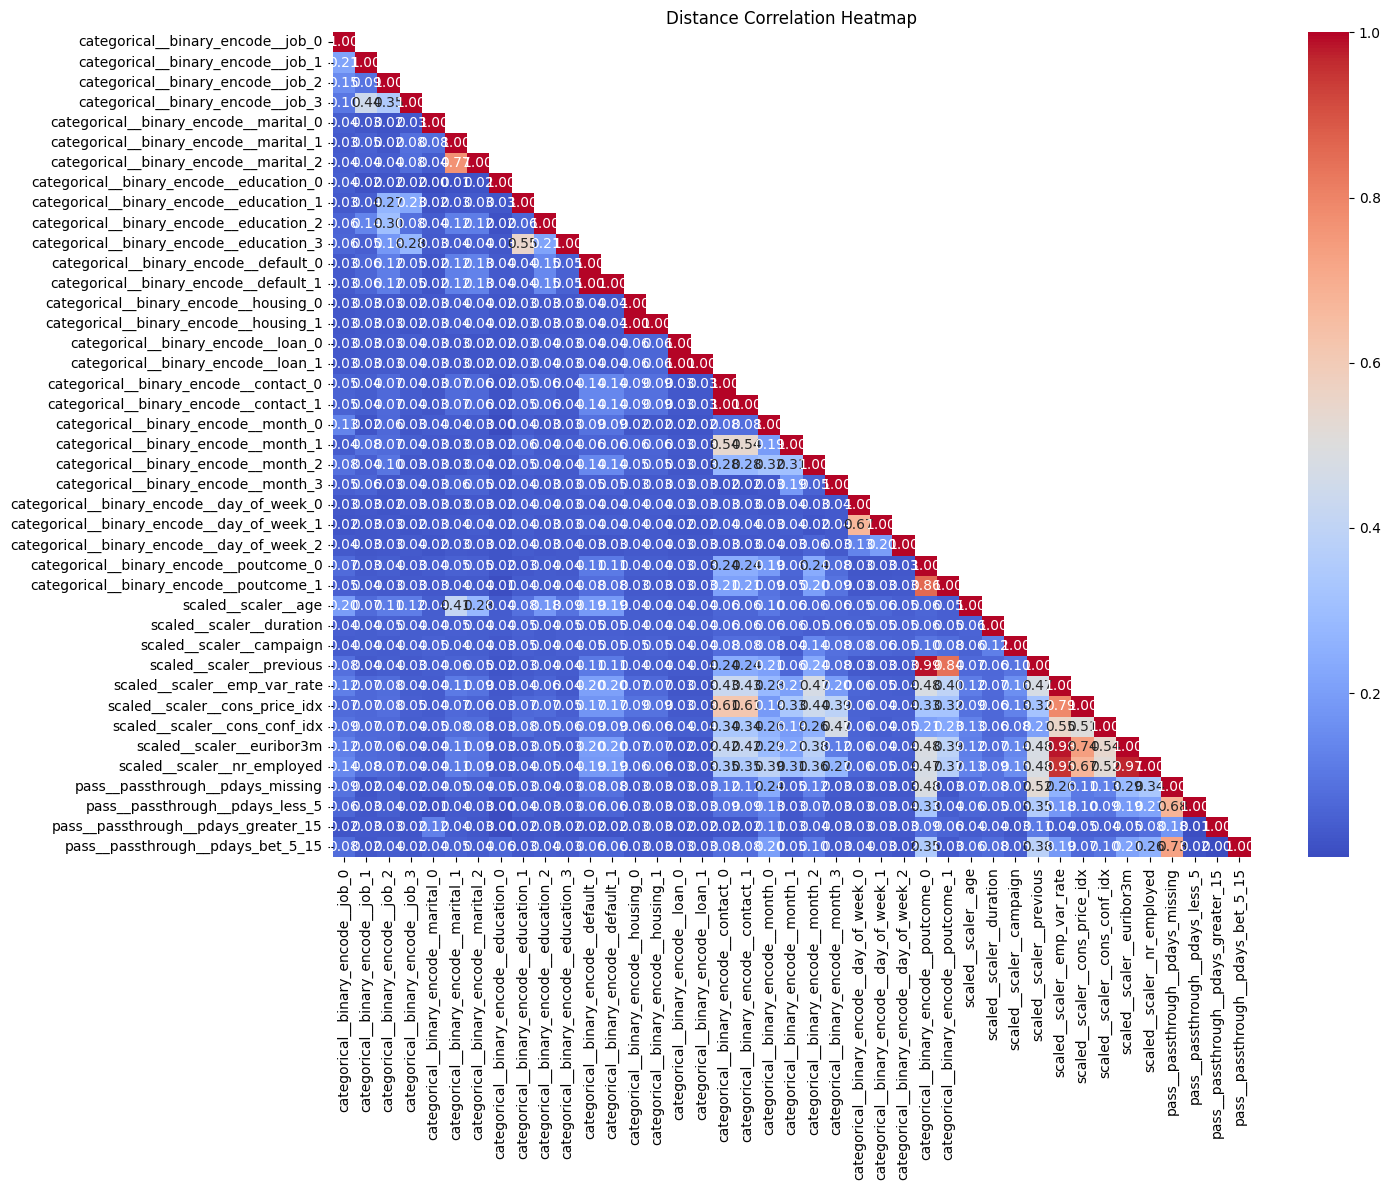


Recommended features to remove:
['categorical__binary_encode__default_0', 'categorical__binary_encode__contact_0', 'categorical__binary_encode__poutcome_1', 'categorical__binary_encode__housing_0', 'categorical__binary_encode__loan_0', 'scaled__scaler__nr_employed', 'scaled__scaler__emp_var_rate', 'categorical__binary_encode__poutcome_0']

Original shape: (24712, 41)
Reduced shape: (24712, 33)


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import os
from tqdm import tqdm

def distance_correlation_optimized(X, Y, batch_size=1000):
    """
    Calculate the distance correlation between two variables using batch processing
    """
    def center_distance_matrix(D):
        n = D.shape[0]
        H = np.eye(n) - np.ones((n, n))/n
        return H.dot(D).dot(H)
    
    # Convert to numpy arrays and reshape if needed
    X = np.asarray(X).reshape(-1, 1) if X.ndim == 1 else np.asarray(X)
    Y = np.asarray(Y).reshape(-1, 1) if Y.ndim == 1 else np.asarray(Y)
    
    n_samples = len(X)
    n_batches = int(np.ceil(n_samples / batch_size))
    
    dcov_xy_sum = 0
    dcov_xx_sum = 0
    dcov_yy_sum = 0
    
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        
        batch_X = X[start_idx:end_idx]
        batch_Y = Y[start_idx:end_idx]
        
        # Calculate pairwise distances for the batch
        X_dist = squareform(pdist(batch_X))
        Y_dist = squareform(pdist(batch_Y))
        
        # Center distance matrices
        X_centered = center_distance_matrix(X_dist)
        Y_centered = center_distance_matrix(Y_dist)
        
        # Accumulate sums
        dcov_xy_sum += np.sum(X_centered * Y_centered)
        dcov_xx_sum += np.sum(X_centered * X_centered)
        dcov_yy_sum += np.sum(Y_centered * Y_centered)
    
    # Calculate final statistics
    n = X.shape[0]
    dcov_xy = np.sqrt(dcov_xy_sum) / n
    dcov_xx = np.sqrt(dcov_xx_sum) / n
    dcov_yy = np.sqrt(dcov_yy_sum) / n
    
    # Calculate distance correlation
    if dcov_xx * dcov_yy == 0:
        dcor = 0
    else:
        dcor = dcov_xy / np.sqrt(dcov_xx * dcov_yy)
    
    return dcor

def calculate_distance_correlation_matrix(X, batch_size=1000, feature_batch_size=10):
    """
    Calculate the distance correlation matrix using batch processing
    """
    n_features = X.shape[1]
    dcor_matrix = np.zeros((n_features, n_features))
    
    # Process features in batches
    for i in range(0, n_features, feature_batch_size):
        end_i = min(i + feature_batch_size, n_features)
        for j in range(i, n_features, feature_batch_size):
            end_j = min(j + feature_batch_size, n_features)
            
            # Process each pair of features in the current batch
            for ii in range(i, end_i):
                for jj in range(max(j, ii), end_j):
                    if ii != jj:
                        dcor = distance_correlation_optimized(
                            X.iloc[:, ii], 
                            X.iloc[:, jj], 
                            batch_size=batch_size
                        )
                        dcor_matrix[ii, jj] = dcor
                        dcor_matrix[jj, ii] = dcor
                    else:
                        dcor_matrix[ii, jj] = 1.0
    
    return pd.DataFrame(dcor_matrix, index=X.columns, columns=X.columns)

def calculate_mutual_information(X, y):
    """
    Calculate mutual information between features and target
    """
    mi_scores = mutual_info_classif(X, y.values.ravel())
    
    mi_df = pd.DataFrame({
        'Feature': X.columns,
        'Mutual Information': mi_scores
    }).sort_values('Mutual Information', ascending=False)
    
    return mi_df

def analyze_feature_importance_and_correlation(X, y, dcor_threshold=0.8, batch_size=1000):
    """
    Comprehensive analysis of feature importance and correlations
    """
    print("Calculating Mutual Information...")
    mi_df = calculate_mutual_information(X, y)
    
    print("\nCalculating Distance Correlation Matrix (this may take a while)...")
    dcor_matrix = calculate_distance_correlation_matrix(X, batch_size=batch_size)
    
    # Find highly correlated features
    high_cor_features = []
    n_features = X.shape[1]
    
    for i in range(n_features):
        for j in range(i+1, n_features):
            if dcor_matrix.iloc[i, j] >= dcor_threshold:
                high_cor_features.append({
                    'Feature1': X.columns[i],
                    'Feature2': X.columns[j],
                    'Distance_Correlation': dcor_matrix.iloc[i, j],
                    'MI_Feature1': mi_df[mi_df['Feature'] == X.columns[i]]['Mutual Information'].values[0],
                    'MI_Feature2': mi_df[mi_df['Feature'] == X.columns[j]]['Mutual Information'].values[0]
                })
    
    high_cor_df = pd.DataFrame(high_cor_features)
    
    return {
        'mutual_information': mi_df,
        'distance_correlation': dcor_matrix,
        'high_correlations': high_cor_df
    }

def plot_results(results):
    """
    Plot analysis results
    """
    # Plot mutual information
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results['mutual_information'].head(10), 
                x='Mutual Information', 
                y='Feature')
    plt.title('Top 10 Features by Mutual Information')
    plt.tight_layout()
    plt.show()
    
    # Plot distance correlation heatmap
    plt.figure(figsize=(15, 12))
    mask = np.triu(np.ones_like(results['distance_correlation']), k=1)
    sns.heatmap(results['distance_correlation'], 
                mask=mask,
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm')
    plt.title('Distance Correlation Heatmap')
    plt.tight_layout()
    plt.show()

def get_features_to_remove(results):
    """
    Determine which features to remove based on correlation and mutual information
    """
    features_to_remove = set()
    
    for _, row in results['high_correlations'].iterrows():
        # Keep the feature with higher mutual information
        if row['MI_Feature1'] < row['MI_Feature2']:
            features_to_remove.add(row['Feature1'])
        else:
            features_to_remove.add(row['Feature2'])
    
    return list(features_to_remove)

def main():
    # Load data
    BASE_PATH = os.path.abspath('..')
    PROCESSED_DATA_PATH = os.path.join(BASE_PATH, 'data', 'processed')
    
    print("Loading data...")
    X_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'X_train.csv'))
    y_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'y_train.csv'))
    
    # Perform analysis
    results = analyze_feature_importance_and_correlation(
        X_train, 
        y_train, 
        dcor_threshold=0.8,
        batch_size=1000
    )
    
    # Plot results
    plot_results(results)
    
    # Get features to remove
    features_to_remove = get_features_to_remove(results)
    print("\nRecommended features to remove:")
    print(features_to_remove)
    
    # Create reduced dataset
    X_train_reduced = X_train.drop(columns=features_to_remove)
    print(f"\nOriginal shape: {X_train.shape}")
    print(f"Reduced shape: {X_train_reduced.shape}")
    
    return X_train_reduced, results

if __name__ == "__main__":
    X_train_reduced, results = main()